In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blk1804/kiba-drug-binding-dataset")

print("Path to dataset files:", path)


Path to dataset files: /home/marci/.cache/kagglehub/datasets/blk1804/kiba-drug-binding-dataset/versions/1
Path to dataset files: /home/marci/.cache/kagglehub/datasets/blk1804/kiba-drug-binding-dataset/versions/1


In [6]:
import pandas as pd

# Assuming the CSV file is named 'data.csv' in the provided path
csv_path = f"{path}/KIBA.csv"
df = pd.read_csv(csv_path)
print(df.head())

       CHEMBLID ProteinID                                compound_iso_smiles  \
0  CHEMBL373751    P53350  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   
1  CHEMBL373751    P00533  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   
2  CHEMBL373751    P04626  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   
3  CHEMBL373751    P49840  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   
4  CHEMBL373751    P49841  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   

                                     target_sequence  \
0  MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...   
1  MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...   
2  MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...   
3  MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGT...   
4  MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...   

   Ki , Kd and IC50  (KIBA Score)  
0                             0.0  
1                             1.1  
2                             1.1  
3                             1.3  
4 

In [7]:
# Rename the last column to 'interaction'
df.rename(columns={'Ki , Kd and IC50  (KIBA Score)': 'interaction'}, inplace=True)
df.rename(columns={'compound_iso_smiles': 'smiles'}, inplace=True)

# Show the distribution of the 'interaction' column
interaction_distribution = df['interaction'].describe()
print(interaction_distribution)

count    118254.000000
mean         11.719935
std           0.836947
min           0.000000
25%          11.200000
50%          11.500000
75%          11.923909
max          17.200180
Name: interaction, dtype: float64


In [8]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
import numpy as np

def smiles_to_maccs_fp(smiles_list):
    fingerprints = []
    
    # MACCS keys produce a 167-bit fingerprint.
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = MACCSkeys.GenMACCSKeys(mol)
            arr = np.zeros((167,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
        else:
            fingerprints.append(np.zeros(167, dtype=np.int8))
    
    return np.array(fingerprints)
def process_smiles_in_batches(smiles_list, batch_size=1000):
    all_fingerprints = []
    
    # Process in batches
    for i in range(0, len(smiles_list), batch_size):
        batch = smiles_list[i:i+batch_size]
        batch_fps = smiles_to_maccs_fp(batch)
        all_fingerprints.append(batch_fps)
        
        
    # Combine results
    return np.vstack(all_fingerprints)

In [9]:
def protein_feature_hashing(protein_sequences, n_features=1000, batch_size=1000):
    from sklearn.feature_extraction.text import HashingVectorizer
    
    all_encodings = []
    vectorizer = HashingVectorizer(n_features=n_features, analyzer='char', ngram_range=(3, 3))
    
    for i in range(0, len(protein_sequences), batch_size):
        batch = protein_sequences[i:i+batch_size]
        encodings = vectorizer.transform(batch).toarray()
        all_encodings.append(encodings)
        
    
    return np.vstack(all_encodings)

In [10]:
def concordance_index(y_true, y_pred):
    """
    Computes the Concordance Index (CI) as used in DeepDTA.
    For each pair of samples with distinct true values, we check if the prediction ordering matches the true ordering.
    Ties in prediction differences count as 0.5.
    """
    n = 0  # Total number of comparable pairs
    n_correct = 0  # Count of correctly ordered pairs
    for i in range(len(y_true)):
        for j in range(i + 1, len(y_true)):
            if y_true[i] != y_true[j]:
                n += 1
                diff_true = y_true[i] - y_true[j]
                diff_pred = y_pred[i] - y_pred[j]
                if diff_true * diff_pred > 0:
                    n_correct += 1
                elif diff_pred == 0:
                    n_correct += 0.5
    return n_correct / n if n > 0 else 0

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Combine feature sets
X_compounds = process_smiles_in_batches(df['smiles'])
print("compounds encoded")
X_proteins = protein_feature_hashing(df['target_sequence'])
print("proteins encoded")

# You can concatenate the features
X = np.hstack((X_compounds, X_proteins))
y = df['interaction']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)


compounds encoded
proteins encoded
proteins encoded


RandomForestRegressor(n_jobs=-1, random_state=42)

In [13]:

# Evaluate
y_pred = model.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")
from lifelines.utils import concordance_index
ci_value = concordance_index(y_test, y_pred)
print("Concordance Index:", ci_value)

# Feature importance for interpretability
feature_importances = model.feature_importances_

MSE: 0.27286430854288973
R2: 0.6043449036109865
Concordance Index: 0.8229810135914797


## Data Visualization

### KIBA Score Distribution\n
Visualize the distribution of the target variable (KIBA score) to understand its characteristics.

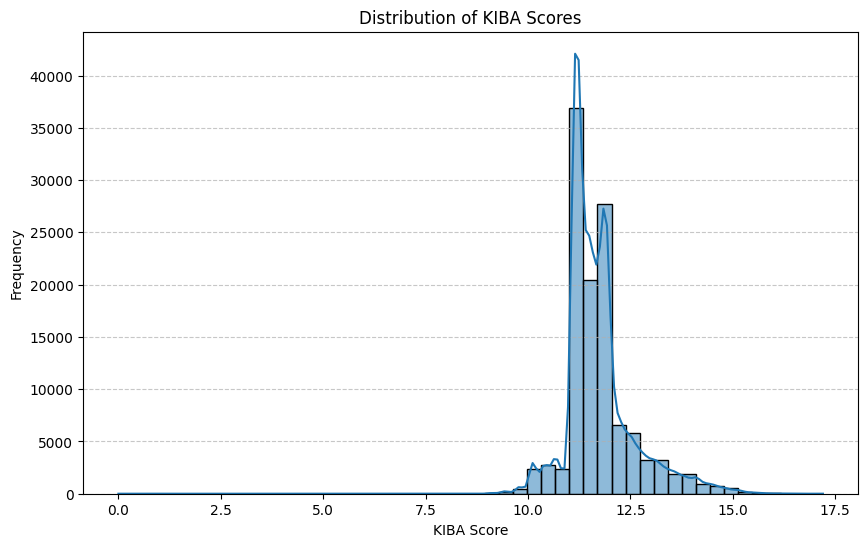

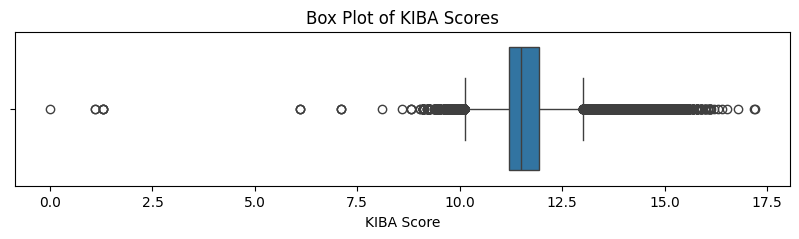

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['interaction'], kde=True, bins=50)
plt.title('Distribution of KIBA Scores')
plt.xlabel('KIBA Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=df['interaction'])
plt.title('Box Plot of KIBA Scores')
plt.xlabel('KIBA Score')
plt.show()

### Molecular Fingerprint Visualization (PCA)\n
Reduce the dimensionality of the 167-bit MACCS fingerprints to 2 dimensions using PCA and visualize the result. This helps to see if there are any inherent clusters or patterns in the molecular structures.

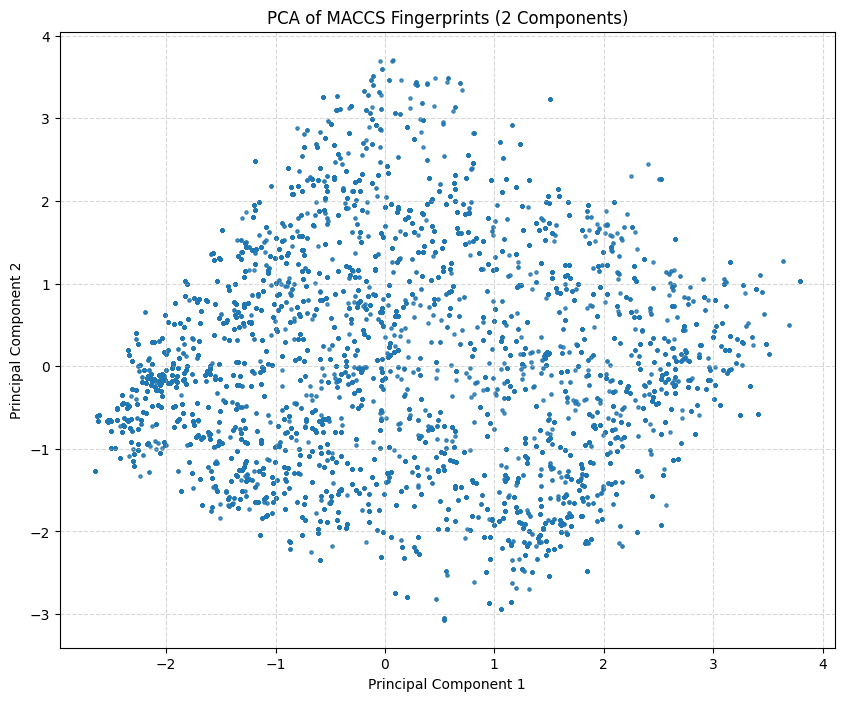

In [16]:
from sklearn.decomposition import PCA

# Reduce dimensionality of compound features
pca_compounds = PCA(n_components=2, random_state=42)
X_compounds_pca = pca_compounds.fit_transform(X_compounds)

plt.figure(figsize=(10, 8))
plt.scatter(X_compounds_pca[:, 0], X_compounds_pca[:, 1], alpha=0.1, s=5) # Use low alpha and small size due to large number of points
plt.title('PCA of MACCS Fingerprints (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Protein Representation Visualization (PCA)\n
Reduce the dimensionality of the 1000-dimension HashingVectorizer protein features to 2 dimensions using PCA and visualize the result. This helps to see if there are patterns in the protein sequence representations.

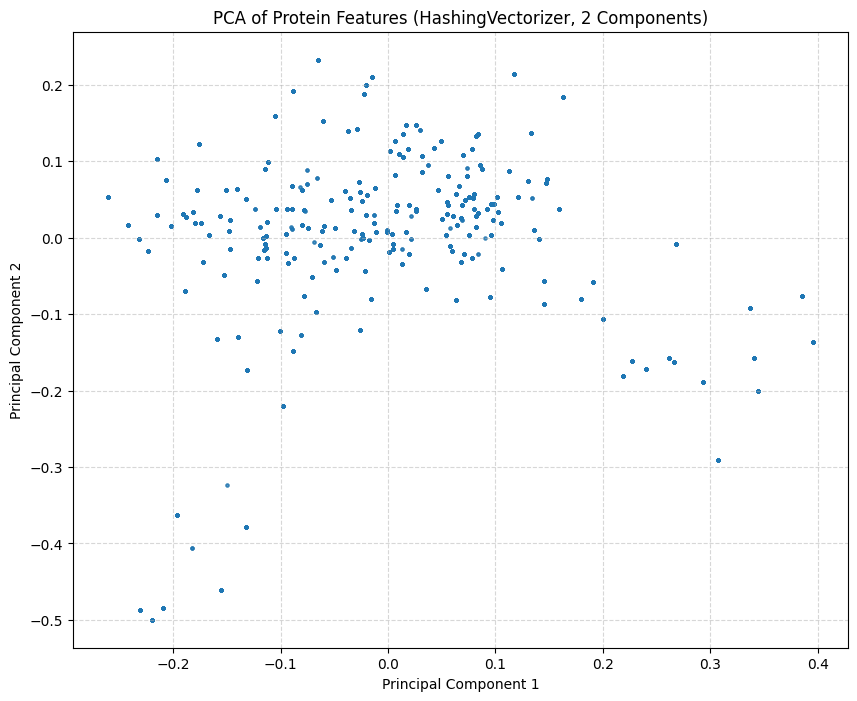

In [17]:
# Reduce dimensionality of protein features
pca_proteins = PCA(n_components=2, random_state=42)
X_proteins_pca = pca_proteins.fit_transform(X_proteins)

plt.figure(figsize=(10, 8))
plt.scatter(X_proteins_pca[:, 0], X_proteins_pca[:, 1], alpha=0.1, s=5)
plt.title('PCA of Protein Features (HashingVectorizer, 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Prediction vs Actual Plot\n
Plot the model's predictions against the actual KIBA scores on the test set. A perfect model would have all points on the y=x line. This plot helps visualize the model's accuracy and identify potential outliers or systematic errors.

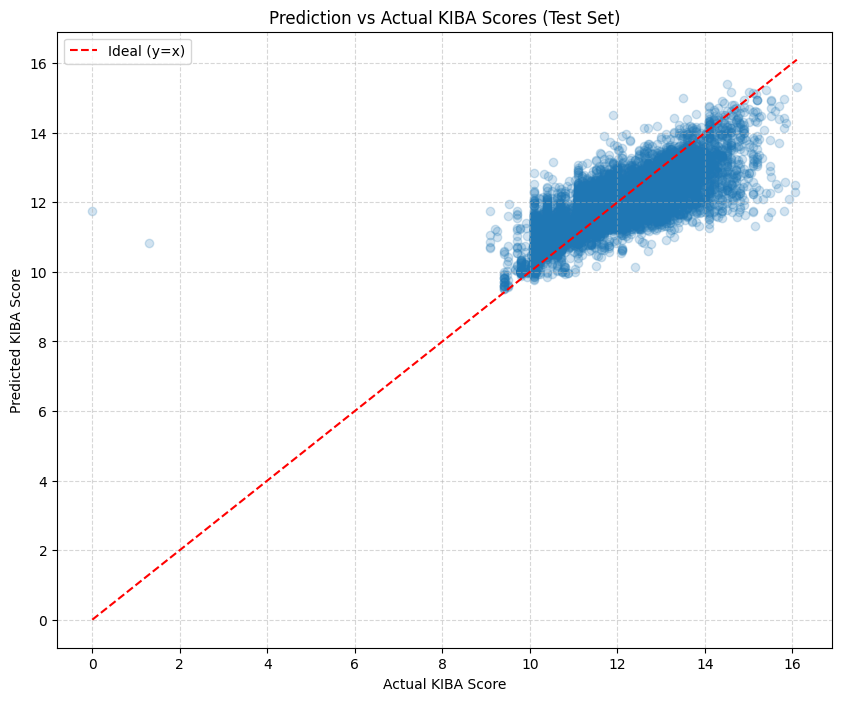

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Ideal (y=x)')
plt.title('Prediction vs Actual KIBA Scores (Test Set)')
plt.xlabel('Actual KIBA Score')
plt.ylabel('Predicted KIBA Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Decoding MACCS Keys\n
The MACCS keys represent specific molecular substructures defined by SMARTS patterns. Let's decode what these top MACCS keys actually mean chemically using the official definitions from RDKit.

In [1]:
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
import pandas as pd

# Get the actual SMARTS patterns directly from RDKit's MACCSkeys module
from rdkit.Chem.MACCSkeys import smartsPatts

# Create a more accurate dictionary for MACCS key definitions
# Including both a human-readable name and the actual SMARTS pattern
maccs_definitions = {
    # Most common/important MACCS keys with more descriptive names
    14: {"name": "S-S bond", "smarts": smartsPatts[14][0]},
    26: {"name": "Conjugated double bond", "smarts": smartsPatts[26][0]},
    55: {"name": "Carboxylic acid", "smarts": smartsPatts[55][0]},
    61: {"name": "Fluorine atom", "smarts": smartsPatts[61][0]},
    66: {"name": "Carbonyl group (C=O)", "smarts": smartsPatts[66][0]},
    70: {"name": "Oxygen atom", "smarts": smartsPatts[70][0]},
    72: {"name": "Hydroxyl group", "smarts": smartsPatts[72][0]},
    74: {"name": "NH group", "smarts": smartsPatts[74][0]},
    80: {"name": "Primary amine", "smarts": smartsPatts[80][0]},
    81: {"name": "C=C (double bond)", "smarts": smartsPatts[81][0]},
    82: {"name": "Nitrogen atom", "smarts": smartsPatts[82][0]},
    85: {"name": "Sulfur atom", "smarts": smartsPatts[85][0]},
    132: {"name": "Ester group", "smarts": smartsPatts[132][0]},
    156: {"name": "Amide/peptide bond", "smarts": smartsPatts[156][0]}
}

# Function to get a descriptive name for a MACCS key
def get_maccs_description(key_idx):
    """Get a descriptive name for a MACCS key, falling back to SMARTS if no custom name"""
    if key_idx in maccs_definitions:
        return f"{maccs_definitions[key_idx]['name']} ({maccs_definitions[key_idx]['smarts']})"
    elif key_idx in smartsPatts:
        # Key exists but no custom name, return the SMARTS pattern
        return smartsPatts[key_idx][0]
    elif key_idx == 1:
        # Special case for bit 1 which is undefined in RDKit
        return "UNDEFINED in RDKit (originally 'ISOTOPE')"
    else:
        # Special cases for bits 125 and 166 which have custom handling in RDKit
        if key_idx == 125:
            return "A!CH3>1 (≥2 methyl groups attached to non-aromatic atoms)"
        elif key_idx == 166:
            return "A!A>2 (≥3 non-H, non-terminal atoms)"
        return "Unknown"

# Create a function to explain the top MACCS keys using SMARTS patterns
def explain_top_maccs_keys(model_importances, n_top=20):
    """
    Explains the chemical significance of the top MACCS keys by importance
    using the actual SMARTS patterns from RDKit
    """
    # Get feature importances
    importances = model_importances
    
    # Create indices array for features
    indices = np.argsort(importances)[::-1]
    
    # Take the top n features (only consider the first 166 indices which are MACCS keys)
    maccs_indices = [idx for idx in indices if idx < 166]
    top_indices = maccs_indices[:n_top]
    top_importances = importances[top_indices]
    
    # Create a dataframe with the MACCS key index, SMARTS pattern, description, and importance
    result_df = pd.DataFrame({
        'MACCS Key': [idx+1 for idx in top_indices],  # 1-indexed for MACCS keys
        'Description': [get_maccs_description(idx+1) for idx in top_indices],
        'Min Matches': [smartsPatts.get(idx+1, (None, 1))[1] if idx+1 in smartsPatts else 'N/A' for idx in top_indices],
        'Importance': top_importances
    }).sort_values('Importance', ascending=False)
    
    return result_df

# Explain the top MACCS keys
top_maccs_explanation = explain_top_maccs_keys(model.feature_importances_)
display(top_maccs_explanation)

NameError: name 'model' is not defined

### Correlation Matrix of Top Features\n
Let's visualize the correlation between the top MACCS keys to understand potential redundancies in the features.

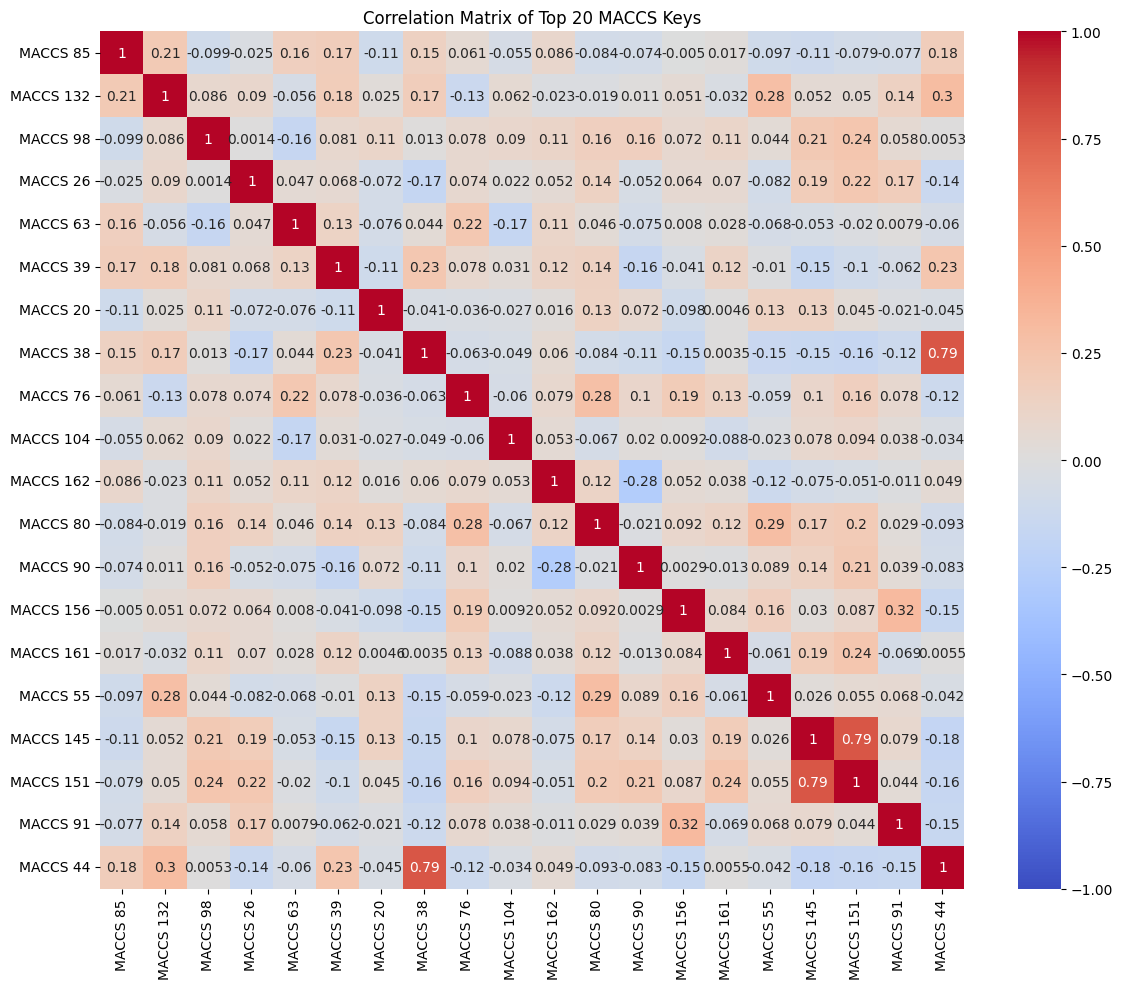

In [21]:
# Extract the top 20 MACCS keys by importance 
top_indices = [key - 1 for key in top_maccs_explanation['MACCS Key'].values[:20]]  # Convert to 0-indexed

# Get the feature values for these keys
top_features = X_compounds[:, top_indices]

# Create a correlation matrix
corr_matrix = np.corrcoef(top_features.T)  # Transpose to get correlations between features

# Create a DataFrame for better visualization
feature_names = [f"MACCS {idx+1}" for idx in top_indices]
corr_df = pd.DataFrame(corr_matrix, index=feature_names, columns=feature_names)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Top 20 MACCS Keys')
plt.tight_layout()
plt.show()